In [1]:
!wget https://www.dropbox.com/scl/fi/owk9udhb67unkxmmpqxuu/data.json?rlkey=epm3joq5td0g1cz8ejxlygxgu&st=jqtho6zp&dl=0
!mv /content/data.json?rlkey=epm3joq5td0g1cz8ejxlygxgu /content/data.json

--2024-06-16 17:21:59--  https://www.dropbox.com/scl/fi/owk9udhb67unkxmmpqxuu/data.json?rlkey=epm3joq5td0g1cz8ejxlygxgu
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1b9a7bb0144f8ae1019a2f19f1.dl.dropboxusercontent.com/cd/0/inline/CU9cOzEy5tLPHg7dTHJYqoMbCtX9WIWMk5PFTRiw08k7joviBGYUpInr_jPwcG4ZzapQv524JVBdNmc9yI_3Vxg_gFhMSQrwQp-mwFp3w9aDjKj45nnAhOJVOoMD_kXM03yO4omAweTs6dTXoe6Ooy1u/file# [following]
--2024-06-16 17:22:00--  https://uc1b9a7bb0144f8ae1019a2f19f1.dl.dropboxusercontent.com/cd/0/inline/CU9cOzEy5tLPHg7dTHJYqoMbCtX9WIWMk5PFTRiw08k7joviBGYUpInr_jPwcG4ZzapQv524JVBdNmc9yI_3Vxg_gFhMSQrwQp-mwFp3w9aDjKj45nnAhOJVOoMD_kXM03yO4omAweTs6dTXoe6Ooy1u/file
Resolving uc1b9a7bb0144f8ae1019a2f19f1.dl.dropboxusercontent.com (uc1b9a7bb0144f8ae1019a2f19f1.dl.dropboxusercontent.com)... 162.125.81.15, 2620:

In [47]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization

In [61]:
DATASET_PATH = '/content/data.json'
EPOCHS = 50
BATCH_SIZE = 32

GENRE = {
    0: 'blues',
    1: 'classical',
    2: 'country',
    3: 'disco',
    4: 'hiphop',
    5: 'jazz',
    6: 'metal',
    7: 'pop',
    8: 'reggae',
    9: 'rock'
}

In [49]:
def load_data(dataset_path):
  with open(dataset_path) as fp:
    data = json.load(fp)

    # convert lists into numpy array
    inputs = np.array(data['mfcc'])
    targets = np.array(data['labels'])

    return inputs, targets

In [50]:
def prepare_datasets(dataset_path, test_size, val_size):
  X, y = load_data(DATASET_PATH)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)

  X_train = X_train[..., np.newaxis]
  X_val = X_val[..., np.newaxis]
  X_test = X_test[..., np.newaxis]

  return X_train, X_val, X_test, y_train, y_val, y_test

In [51]:
def create_model(input_shape):

  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
  model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
  model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same'))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=(2,2), activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))
  model.add(BatchNormalization())

  model.add(Flatten())

  model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.3))

  model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.3))

  model.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.3))

  model.add(Dense(units=10, activation='softmax'))

  return model

In [65]:
def predict(model, X):
  X = X[np.newaxis, ...]

  y_pred = model.predict(X, verbose=0)
  y_pred = np.argmax(y_pred, axis=1)

  return y_pred[0]

In [52]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(DATASET_PATH, test_size=0.25, val_size=0.2)

In [53]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = create_model(input_shape)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 64, 6, 32)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_15 (Ba  (None, 64, 6, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_16 (Conv2D)          (None, 62, 4, 64)         18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 31, 2, 64)         0         
 ng2D)                                                           
                                                      

In [54]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=5,
                              restore_best_weights=True,
                              verbose=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        factor=0.5,
                                        verbose=True)

checkpoint = ModelCheckpoint('best_weights.keras', save_best_only=True, monitor='val_accuracy', mode='max')
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [55]:
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpoint, early_stopping, reduce_learning_rate], verbose=2)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/50
188/188 - 6s - loss: 2.8874 - accuracy: 0.1542 - val_loss: 2.3818 - val_accuracy: 0.3280 - 6s/epoch - 34ms/step
Epoch 2/50
188/188 - 3s - loss: 2.4783 - accuracy: 0.2490 - val_loss: 2.1399 - val_accuracy: 0.4140 - 3s/epoch - 14ms/step
Epoch 3/50
188/188 - 2s - loss: 2.3367 - accuracy: 0.3005 - val_loss: 1.9937 - val_accuracy: 0.4640 - 2s/epoch - 13ms/step
Epoch 4/50
188/188 - 2s - loss: 2.2080 - accuracy: 0.3502 - val_loss: 1.8831 - val_accuracy: 0.4867 - 2s/epoch - 9ms/step
Epoch 5/50
188/188 - 2s - loss: 2.1417 - accuracy: 0.3790 - val_loss: 1.8069 - val_accuracy: 0.5067 - 2s/epoch - 11ms/step
Epoch 6/50
188/188 - 2s - loss: 2.0587 - accuracy: 0.3924 - val_loss: 1.7678 - val_accuracy: 0.5187 - 2s/epoch - 10ms/step
Epoch 7/50
188/188 - 2s - loss: 1.9964 - accuracy: 0.4219 - val_loss: 1.6993 - val_accuracy: 0.5453 - 2s/epoch - 10ms/step
Epoch 8/50
188/188 - 2s - loss: 1.9433 - accuracy: 0.4417 - val_loss: 1.6421 - val_accuracy: 0.5593 - 2s/epoch - 9ms/step
Epoch 9/50
188/188

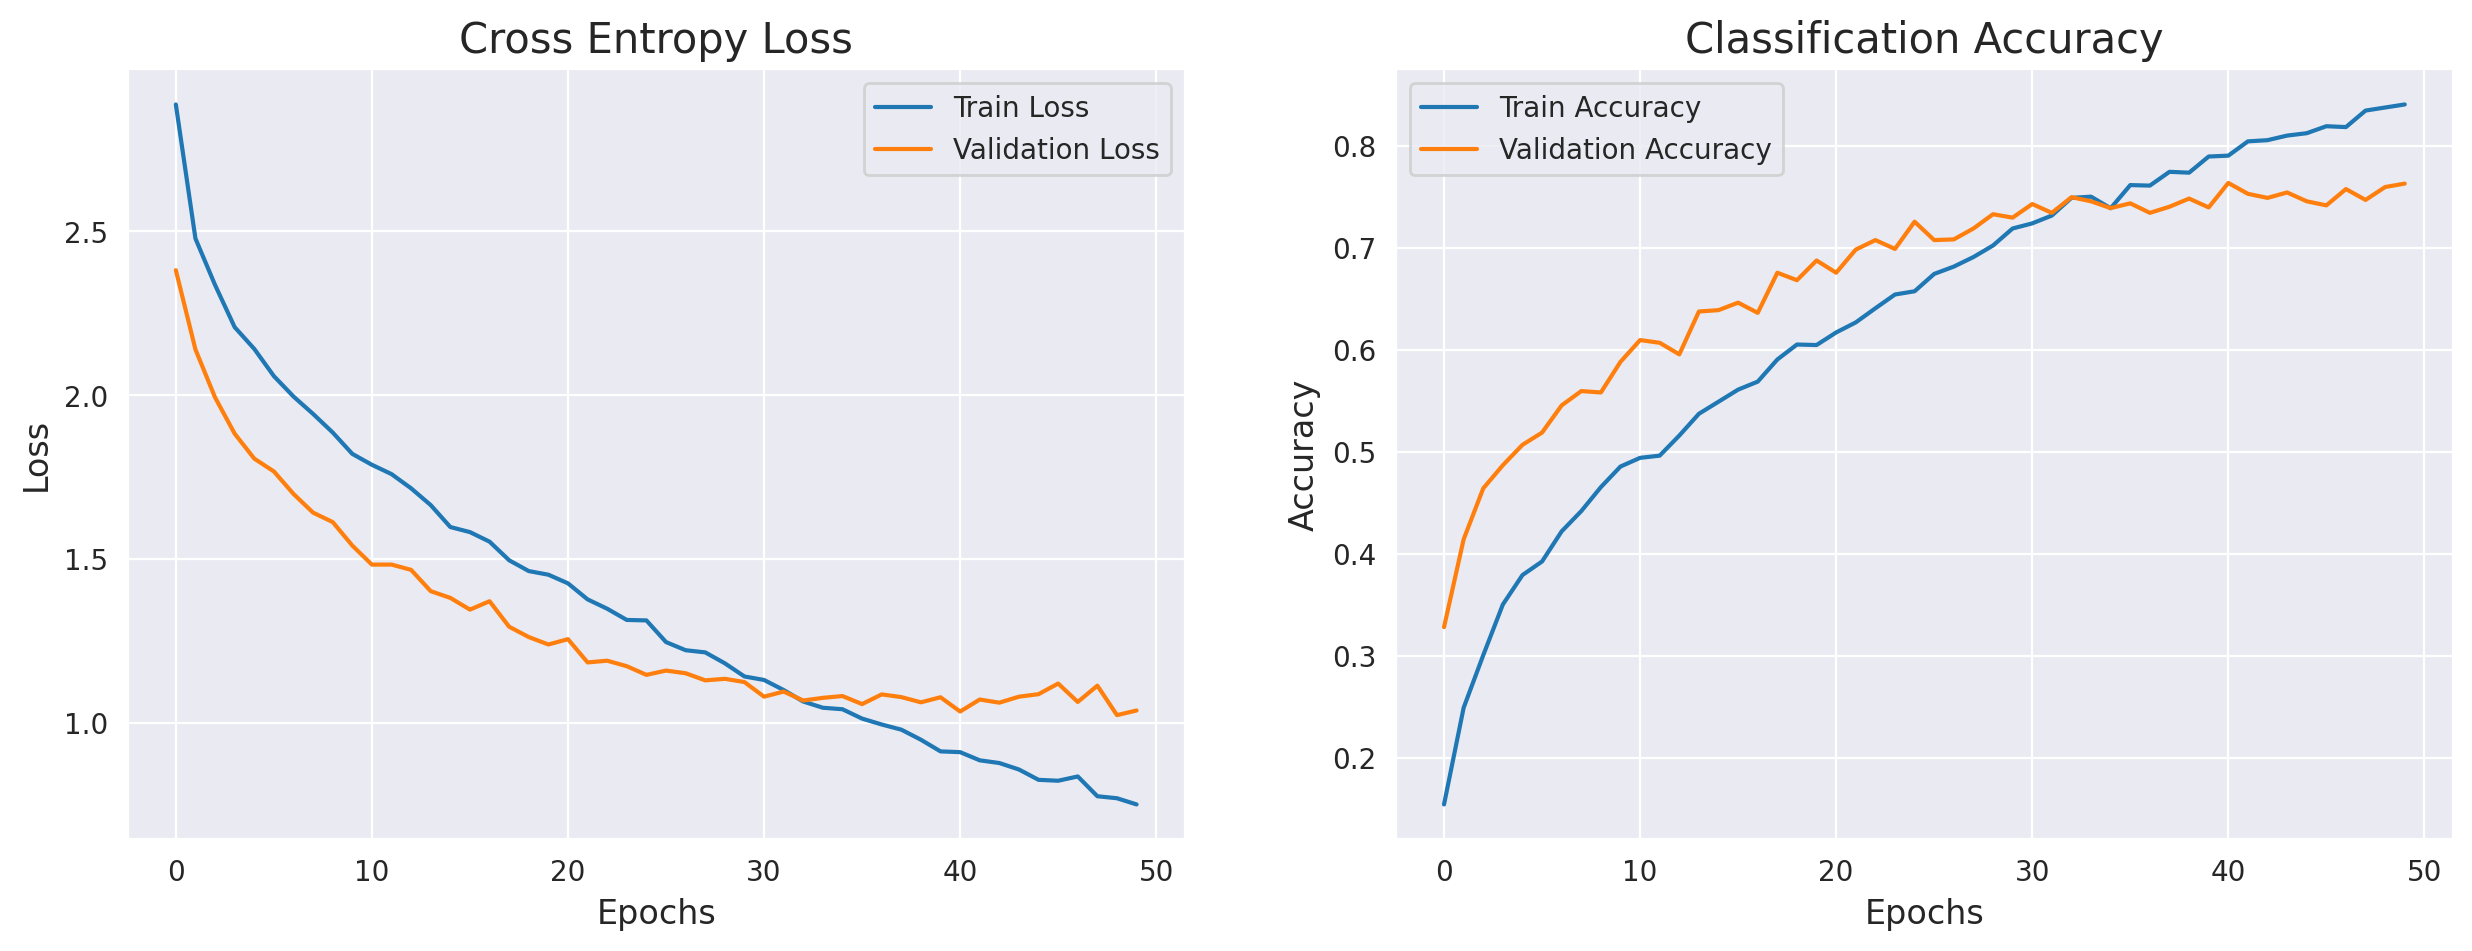

In [56]:
metrics = pd.DataFrame(model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [64]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Error: {test_error}')
print(f'Test Accuracy: {test_accuracy}')

Test Error: 1.0959174633026123
Test Accuracy: 0.756302535533905


In [69]:
X = X_test[100]
y = y_test[100]

y_pred = predict(model, X)

print(f'Actual class: {GENRE[y]}')
print(f'Predicted class: {GENRE[y_pred]}')

Actual class: country
Predicted class: country
